# Visualize some data

In [8]:
from pathlib import Path
from py_module.data_display import get_data_paths, display_nomenclature, display_samples, display_all_with_semantic_class, display_all

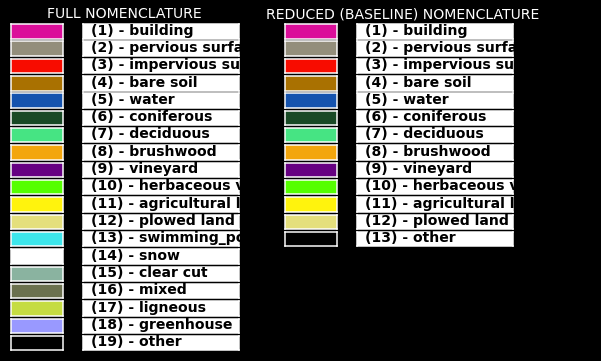

In [9]:
display_nomenclature(size='small')

# Imports and GPU-check

In [10]:
#general 
import os
import numpy as np
import json
import random
from pathlib import Path 
import matplotlib.pyplot as plt

#deep learning
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar
from pytorch_lightning import Trainer, seed_everything
try:
  from pytorch_lightning.utilities.distributed import rank_zero_only
except ImportError:
  from pytorch_lightning.utilities.rank_zero import rank_zero_only  

import albumentations as A

#flair-one baseline modules 
from py_module.utils import load_data, subset_debug
from py_module.datamodule import OCS_DataModule
from py_module.model import SMP_Unet_meta
from py_module.task_module import SegmentationTask
from py_module.writer import PredictionWriter

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0: print('No GPU found.')
else: print(gpu_info)

Mon Mar 27 10:49:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0  On |                  N/A |
| 24%   31C    P8    24W / 215W |    389MiB /  7981MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data paths and parameters

In [ ]:
##############################################################################################
# paths and naming FULL DATASET
path_data = "/home/tgrippa/project/weak_flair/" # toy (or full) dataset folder
path_metadata_file = "/home/tgrippa/project/weak_flair/flair-one_metadata.json" # json file containing the metadata

out_folder = "/home/tgrippa/project/weak_flair/experiments" # output directory for logs and predictions.
out_model_name = "flair-one-baseline_argu" # to keep track
##############################################################################################

In [ ]:
##############################################################################################
# tasking
use_weights = True 
class_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0]

use_metadata = False
use_augmentation = False
##############################################################################################

##############################################################################################
# training hyper-parameters
batch_size = 18
learning_rate = 0.5
num_epochs = 20
##############################################################################################

##############################################################################################
# display
enable_progress_bar = True
progress_rate = 10 #tqdm update rate during training 
##############################################################################################

In [ ]:
##############################################################################################
# computational ressources
accelerator = 'gpu' # set to 'cpu' if GPU not available
gpus_per_node = 1 # set to 1 if mono-GPU
num_nodes = 1 # set to 1 if mono-GPU
strategy = None # Put this parameter to None if train on only one GPU or on CPUs. If multiple GPU, set to 'ddp' (for script). If multiple GPU with interactive environment like Jupyter, set to 'ddp_fork'
num_workers = 0
##############################################################################################

# DataLoaders

In [9]:
out_dir = Path(out_folder, out_model_name)
out_dir.mkdir(parents=True, exist_ok=True)

seed_everything(2022, workers=True)

subset_train = 0.25 # 100% of train data
subset_val = 0.25  # 100% of val data
subset_test = 0.25 # 100% of test set 

@rank_zero_only
def step_loading(path_data, path_metadata_file: str, use_metadata: bool) -> dict:
    print('+'+'-'*29+'+', '   LOADING DATA   ', '+'+'-'*29+'+')
    train, val, test = load_data(path_data, path_metadata_file, use_metadata=use_metadata)
    return train, val, test

@rank_zero_only
def print_recap():
    print('\n+'+'='*80+'+',f"{'Model name: '+out_model_name : ^80}", '+'+'='*80+'+', f"{'[---TASKING---]'}", sep='\n')
    for info, val in zip(["use weights", "use metadata", "use augmentation"], [use_weights, use_metadata, use_augmentation]): print(f"- {info:25s}: {'':3s}{val}")
    print('\n+'+'-'*80+'+', f"{'[---DATA SPLIT---]'}", sep='\n')
    for split_name, d in zip(["train", "val", "test"], [dict_train, dict_val, dict_test]): print(f"- {split_name:25s}: {'':3s}{len(d['IMG'])} samples")
    print('\n+'+'-'*80+'+', f"{'[---HYPER-PARAMETERS---]'}", sep='\n')
    for info, val in zip(["batch size", "learning rate", "epochs", "nodes", "GPU per nodes", "accelerator", "workers"], [batch_size, learning_rate, num_epochs, num_nodes, gpus_per_node, accelerator, num_workers]): print(f"- {info:25s}: {'':3s}{val}")        
    print('\n+'+'-'*80+'+', '\n')

def subset_selection(dict_set, subset_idx):    
    for k in dict_set.keys():
        if isinstance(subset_idx,float):
            subset_idx = int(len(dict_set[k])*subset_idx)
        dict_set[k] = dict_set[k][:subset_idx]
    return dict_set

dict_train, dict_val, dict_test = step_loading(path_data, path_metadata_file, use_metadata=use_metadata)  
dict_train = subset_selection(dict_train, subset_train) 
dict_val = subset_selection(dict_val, subset_val) 
dict_test = subset_selection(dict_test, subset_test) 

print_recap()

if use_augmentation == True:
    transform_set = A.Compose([A.VerticalFlip(p=0.5),
                               A.HorizontalFlip(p=0.5),
                               A.RandomRotate90(p=0.5)])
else:
    transform_set = None

dm = OCS_DataModule(
    dict_train=dict_train,
    dict_val=dict_val,
    dict_test=dict_test,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    num_classes=13,
    num_channels=5,
    use_metadata=use_metadata,
    use_augmentations=transform_set)

Global seed set to 2022


+-----------------------------+    LOADING DATA    +-----------------------------+

+================================================================================+
                      Model name: flair-one-baseline_argu                       
+================================================================================+
[---TASKING---]
- use weights              :    True
- use metadata             :    False
- use augmentation         :    False

+--------------------------------------------------------------------------------+
[---DATA SPLIT---]
- train                    :    425 samples
- val                      :    312 samples
- test                     :    125 samples

+--------------------------------------------------------------------------------+
[---HYPER-PARAMETERS---]
- batch size               :    18
- learning rate            :    0.5
- epochs                   :    20
- nodes                    :    1
- GPU per nodes            :    1
- accelerator         

# Learning setup

In [10]:
# Download Unet with pre-trianed ResNet34 as backbone
model = SMP_Unet_meta(n_channels=5, n_classes=13, use_metadata=use_metadata)

In [11]:
from lightning.pytorch.loggers import WandbLogger

ModuleNotFoundError: No module named 'lightning'

### Loss

In [144]:
if use_weights == True:
    with torch.no_grad():
        class_weights = torch.FloatTensor(class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()

### Optimizer

In [145]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Scheduler

In [146]:
scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.5,
    patience=10,
    cooldown=4,
    min_lr=1e-7,
)

### Pytorch lightning module

In [147]:
seg_module = SegmentationTask(
    model=model,
    num_classes=dm.num_classes,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    use_metadata=use_metadata
)

### Callbacks

In [148]:
ckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=os.path.join(out_dir,"checkpoints"),
    filename="ckpt-{epoch:02d}-{val_loss:.2f}"+'_'+out_model_name,
    save_top_k=1,
    mode="min",
    save_weights_only=True, # can be changed accordingly
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=30, # if no improvement after 30 epoch, stop learning. 
    mode="min",
)

prog_rate = TQDMProgressBar(refresh_rate=progress_rate)

callbacks = [
    ckpt_callback, 
    early_stop_callback,
    prog_rate,
]

### Loggers

In [149]:
logger = TensorBoardLogger(
    save_dir=out_dir,
    name=Path("tensorboard_logs"+'_'+out_model_name).as_posix()
)

loggers = [
    logger
]

# Launch training

Defining a `Trainer` allows for to automate tasks, such as enabling/disabling grads, running the dataloaders or invoking the callbacks when needed.

In [150]:
#### instanciation of Trainer
trainer = Trainer(
    accelerator=accelerator,
    devices=gpus_per_node,
    strategy=strategy,
    num_nodes=num_nodes,
    max_epochs=num_epochs,
    num_sanity_val_steps=0,
    callbacks = callbacks,
    logger=loggers,
    enable_progress_bar = enable_progress_bar,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [151]:
trainer.fit(seg_module, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                   | Params
---------------------------------------------------------
0 | model         | SMP_Unet_meta          | 24.4 M
1 | criterion     | CrossEntropyLoss       | 0     
2 | train_metrics | MulticlassJaccardIndex | 0     
3 | val_metrics   | MulticlassJaccardIndex | 0     
4 | train_loss    | MeanMetric             | 0     
5 | val_loss      | MeanMetric             | 0     
---------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.778    Total estimated model params size (MB)


Epoch 0:  50%|▌| 20/40 [01:08<01:08,
Validation: 0it [00:00, ?it/s]
Validation:   0%| | 0/17 [00:00<?, ?
Epoch 0:  75%|▊| 30/40 [02:25<00:48,
Validation DataLoader 0:  59%|▌| 10/
Epoch 0: 100%|█| 40/40 [03:39<00:00,
Epoch 1:  50%|▌| 20/40 [00:59<00:59,
Validation: 0it [00:00, ?it/s]
Validation:   0%| | 0/17 [00:00<?, ?
Epoch 1:  75%|▊| 30/40 [02:04<00:41,
Validation DataLoader 0:  59%|▌| 10/
Epoch 1: 100%|█| 40/40 [03:04<00:00,
Epoch 2:  50%|▌| 20/40 [01:00<01:00,
Validation: 0it [00:00, ?it/s]
Validation:   0%| | 0/17 [00:00<?, ?
Epoch 2:  75%|▊| 30/40 [01:59<00:39,
Validation DataLoader 0:  59%|▌| 10/
Epoch 2: 100%|█| 40/40 [02:58<00:00,
Epoch 3:  50%|▌| 20/40 [01:11<01:11,
Validation: 0it [00:00, ?it/s]
Validation:   0%| | 0/17 [00:00<?, ?
Epoch 3:  75%|▊| 30/40 [02:30<00:50,
Validation DataLoader 0:  59%|▌| 10/
Epoch 3: 100%|█| 40/40 [03:29<00:00,
Epoch 4:  50%|▌| 20/40 [01:08<01:08,
Validation: 0it [00:00, ?it/s]
Validation:   0%| | 0/17 [00:00<?, ?
Epoch 4:  75%|▊| 30/40 [01:56<0

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 40/40 [03:11<00:00


# Validate

In [152]:
trainer.validate(seg_module, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation DataLoader 0: 100%|█| 17/
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             1.72761869430542
        val_miou            0.21177616715431213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.72761869430542, 'val_miou': 0.21177616715431213}]

# Inference and prediction export

In [153]:
writer_callback = PredictionWriter(        
    output_dir=os.path.join(out_dir, "predictions"+"_"+out_model_name),
    write_interval="batch",
)

#### instanciation of prediction Trainer
trainer = Trainer(
    accelerator=accelerator,
    devices=gpus_per_node,
    strategy=strategy,
    num_nodes=num_nodes,
    callbacks = [writer_callback],
    enable_progress_bar = enable_progress_bar,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [154]:
trainer.predict(seg_module, datamodule=dm)

@rank_zero_only
def print_finish():
    print('--  [FINISHED.]  --', f'output dir : {out_dir}', sep='\n')
print_finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|█| 125
--  [FINISHED.]  --
output dir : /home/tgrippa/project/weak_flair/experiments/flair-one-baseline_argu


# Visual checking of predictions

In [155]:
from py_module.data_display import display_predictions, get_data_paths

images_test = dict_test['IMG']
predictions = sorted(list(get_data_paths(Path(out_dir, "predictions"+'_'+out_model_name), 'PRED*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))

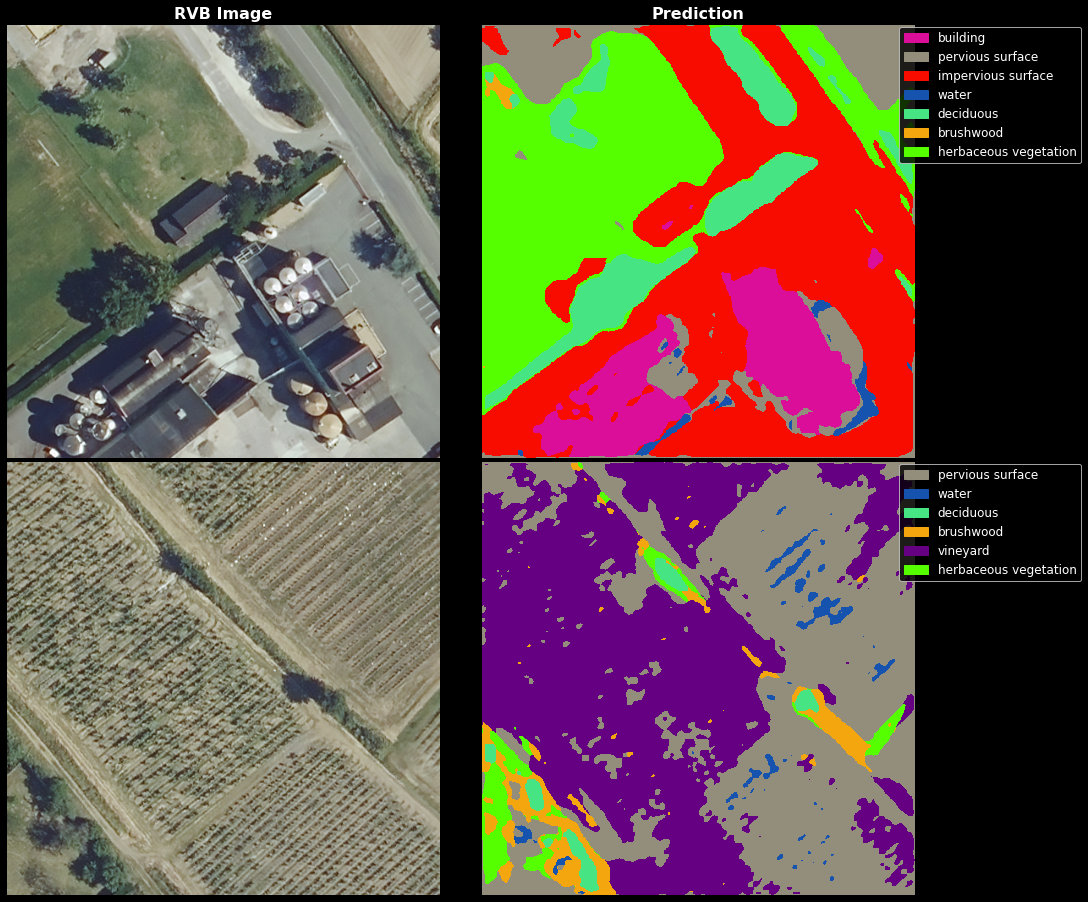

In [156]:
display_predictions(images_test, predictions, nb_samples=2)